<center> <h1> <b> AIET Tutorial </b> </h1> </center>

<b> AIET Tutorial on Speech Processing </b>

Welcome to the tutorial on speech processing.





<h4> <b> Part1: Voiced / Unvoiced Detection : </b>   </h4>

<dt> <h4> 1. Frame the signal </h4> </dt>

<dd> <h4> -  The below figure illustrates the concept of framming the signal. The figure shows that the given speech signal is framed into multiple frames with a frame size of 400 samples and a frameshift of 160 samples. </h4> </dd>

<img src ="https://raw.githubusercontent.com/Sreeakanth/SpeechSystems/main/Framing.png" >


<dt> <h4> 2. Voiced / Unvoiced Detection </h4> </dt>

<dd> <h4> - Auto correlation sequence of a mean substracted frame x[n] </h4>  </dd>

<dd> <h4>  <center> $r_{xx}$[k] = $\frac{1}{r_{xx}[0]}\sum_{n=0}^{N}$ x[n]x[n+k]
$\;\;\;\;$ k = ...,-2,-1,0,1,2,... </center> </h4>  </dd>



<dd> <h4> - The below figure shows the autocorrelation sequence for both voiced and unvoiced frames  </h4>  </dd>

<img src ="https://raw.githubusercontent.com/Sreeakanth/SpeechSystems/master/VoicedUnvoiced.png" width = "800px" height = "400px" >

<dd> <h4> - The figure shows that the voiced or unvoiced decision can be made using the strength of the second peak in the autocorrelation sequence. </h4>  </dd>


<dd> <h4> - If the frame is voiced, The pitch period can be computed from the location of the second peak in the autocorrelation sequence. </h4>  </dd>  

[link to data](https://drive.google.com/drive/folders/1gOraB1OC3x1QczkZJL_E9wxspD_0Db3S?usp=sharing)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def FrameSig(input,frameSize=400,frameShift=160,padding=False,window=None):
    # Takes signal as input and returns a sequence of windowed signals
    '''
    Example :- samplingRate =16000, frameSize= 0.025 sec, frameShift = 0.010 sec
    Input  = (1,16000*5) # The size of the 5 second speech signal with 16 kHz sampling rate
    Output = (500,400) # Here 500 is the number of frames and 400 is the number of samples in the frame
    '''
    #####################################
    # Complete the code
    if window=='hamming': w = 0.54-0.46*np.cos(2*np.pi*np.arange(frameSize)/(frameSize-1))
    else: w=np.ones(frameSize)
    output = []
    for si in range(0, len(input), frameShift):
      if(si+frameSize<=len(input)):
        fr = input[si:si+frameSize]
        output.append(fr*w)
      elif padding:
        fr = np.concatenate([input[si:], np.zeros(si+frameSize-len(input))], axis=0)
        output.append(fr*w)
    return np.asarray(output)
    #####################################

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def AutoCorrelation(framed_signal):
    # Takes frame as input and returns auto correlation sequence of the frame
    '''
    Input = (1,samplingRate*frameDuration)
    Output = (samplingRate*frameDuration) # auto correlation sequence is symmetric
    '''
    #####################################
    # Complete the code
    Rxx = []
    for fi in range(len(framed_signal)):
      rxx = []
      for k in range(len(framed_signal[fi])):
        rxx.append(np.sum(framed_signal[fi]*np.concatenate([np.zeros(k), framed_signal[fi,:len(framed_signal[fi])-k]], axis=0)))
      Rxx.append(np.asarray(rxx/rxx[0]))
    return np.asarray(Rxx)
    #####################################

def find_peaks(x, height_threshold=0.2, width_threshold=15, distance_threshold=32):
    peaks = []
    i=1;i_max=x.shape[0]-1
    while i<i_max:
            if x[i - 1] < x[i]:
                i_ahead = i + 1
                while i_ahead < i_max and x[i_ahead] == x[i]:
                    i_ahead += 1
                if x[i_ahead] < x[i]:
                    peaks.append(((i + i_ahead - 1)//2))
                    i = i_ahead
            i += 1
    peaks = np.asarray(peaks)
    keep = np.ones(peaks.shape[0], dtype=bool)
    min_heighted_peaks = keep & (x[peaks]>=height_threshold)
    peaks = peaks[min_heighted_peaks]

    rel_height=0.8
    wlen=30
    widths = []
    for peak_nr in range(peaks.shape[0]):
        peak = peaks[peak_nr]
        i_min = 0
        i_max = x.shape[0] - 1
        if 2 <= wlen:
            i_min = max(peak - wlen // 2, i_min)
            i_max = min(peak + wlen // 2, i_max)
        i = left_base = peak
        left_min = x[peak]
        while i_min <= i and x[i] <= x[peak]:
            if x[i] < left_min:
                left_min = x[i]
                left_base = i
            i -= 1
        i = right_base = peak
        right_min = x[peak]
        while i <= i_max and x[i] <= x[peak]:
            if x[i] < right_min:
                right_min = x[i]
                right_base = i
            i += 1

        prominence = x[peak] - max(left_min, right_min)

        height = width_height = x[peak] - prominence * rel_height
        i = peak
        while i_min < i and height < x[i]:
            i -= 1
        left_ip = i*1.
        if x[i] < height:
            left_ip += (height - x[i]) / (x[i + 1] - x[i])

        i = peak
        while i < i_max and height < x[i]:
            i += 1
        right_ip = i*1.
        if  x[i] < height:
            right_ip -= (height - x[i]) / (x[i - 1] - x[i])

        widths.append(right_ip - left_ip)
    widths = np.asarray(widths)
    peaks = peaks[widths>=width_threshold]

    peaks = np.concatenate([[0], peaks], axis=0)

    priorities = np.argsort(x[peaks])
    keep = np.ones(peaks.shape[0])
    for i in range(peaks.shape[0]-1, -1, -1):
        j = priorities[i]
        if keep[j] == 0:
            continue

        k = j - 1
        while 0 <= k and peaks[j] - peaks[k] < distance_threshold:
            keep[k] = 0
            k -= 1
        k = j + 1
        while k < peaks.shape[0] and peaks[k] - peaks[j] < distance_threshold:
            keep[k] = 0
            k += 1
    keep = np.ndarray.astype(keep, dtype=bool)
    peaks = peaks[keep]

    return peaks

def get_f0(Rxx, height_threshold, width_threshold, distance_threshold):
    # Extracts the fundamental frequency from the autocorrelation sequence
    # Location of the second peak in the autocorrelation sequence gives the pitch period
    #####################################
    # Complete the code
    f0 = []
    fs = 16000
    for fi in range(len(Rxx)):
      peaks = find_peaks(Rxx[fi], height_threshold, width_threshold, distance_threshold)
      if len(peaks)>=2 and peaks[1]<=200:
        f0.append(fs/peaks[1])
      else:
        f0.append(0)
    return f0
    #####################################

def get_voiced(Rxx, height_threshold, width_threshold, distance_threshold):
    # Returns voiced/unvoiced frame decision from the auto correlation sequence
    #####################################
    # Complete the code
    voiced_flag = []
    for fi in range(len(Rxx)):
      peaks = find_peaks(Rxx[fi], height_threshold, width_threshold, distance_threshold)
      if len(peaks)>=2 and peaks[1]<=200:
        voiced_flag.append(1)
      else:
        voiced_flag.append(0)
    return np.ndarray.astype(np.asarray(voiced_flag), dtype=bool)
    #####################################

def VoicedVSUnvoiced(framed_signal, height_threshold, width_threshold, distance_threshold):
    # Given a frame , returns whether the frame is voiced or unvoiced
    #If the frame is voiced, The code returns the pitch of the voiced frame
    #If the frame is unvoiced. The code returns some constant ( dummy ) value as pitch ( It will help in filtering out unvoiced frames )
    '''
    Input = signal frame (or) N number of frames
    Output = Binary flag indicating voicing decision and the pitch of the voiced frames
    '''
    #####################################
    # Complete the code
    #####################################
    Rxx = AutoCorrelation(framed_signal) #Auto correlation function
    voiced_flags = get_voiced(Rxx, height_threshold, width_threshold, distance_threshold)
    estimated_F0 = get_f0(Rxx, height_threshold, width_threshold, distance_threshold) # extracts fundamental frequency of voiced frames
    ##################################### Set fundamental frequency of unvoiced frames as zero or None , This helps in filtering out these frames later
    #####################################
    return voiced_flags,estimated_F0 # return voiced and unvoiced decision and estimated pitch ( for voiced frames it is actual pitch, for unvoiced frames it is dummy ( either 0 or None ) )

In [ ]:
import numpy as np

def Energy(frame):
    #Returns the energy of the signal
    return np.sum((np.absolute(frame))**2)

def NonSpeechVsSpeech(framed_signal,voiced_flags, threshold):
    #Given an unvoiced frame, returns whether the unvoiced frame contains speech information ( fricatives or a few stop consonants etc )  or silence
    unvoiced_flags = np.zeros(len(voiced_flags))
    silence_flags = np.zeros(len(voiced_flags))
    for fi in range(len(framed_signal)):
      if not(voiced_flags[fi]):
        energy = Energy(framed_signal[fi])
        if energy>=threshold:
          unvoiced_flags[fi] = 1.
        else:
          silence_flags[fi] = 1.
    return np.ndarray.astype(unvoiced_flags, dtype=bool),np.ndarray.astype(silence_flags, dtype=bool) # returns decision/boolean indicating whether the unvoiced frame belongs to silence or contains speech information

In [ ]:
#All imports
import numpy as np
import scipy.io.wavfile
import soundfile as sf
from google.colab import drive


###########################
# Read wavefile
###########################

#wavefile location in drive
wavefile = '/content/drive/MyDrive/TalentSprint/Session3/clean_signal.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)


###########################
# Substract the mean of the speech signal.
###########################

sig=sig-np.mean(sig)
sig = sig/max(abs(sig))

###########################
# Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
###########################

frameSize = 400
frameShift = 160
windowing = 'hamming'
framed_signal = FrameSig(sig,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

peak_threshold = 0.2         #set the threshold of the second peak in auto correlation sequence
width_threshold = 15
distance_threshold = 48      # 2ms
voiced_flags,estimated_pitch=VoicedVSUnvoiced(framed_signal,peak_threshold, width_threshold, distance_threshold)
###########################
# Classifying the silence from unvoiced frames
###########################

#UnvoicedFrames =          #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence
energy_threshold = 1e-3      #set energy threshold for fricative vs silence frame detection from the unvoiced frames
unvoiced_flags, silence_flags = NonSpeechVsSpeech(framed_signal,voiced_flags, energy_threshold)
#voiced_unvoiced_silence_flags = voiced_flags*1 + vad_flags*1


In [ ]:
#All imports
import numpy as np
import scipy.io.wavfile
import soundfile as sf
from google.colab import drive


###########################
# Read wavefile
###########################



#wavefile location in drive
wavefile = '/content/drive/MyDrive/TalentSprint/Session3/clean_signal.wav'
#wavefile reading
(rate,sig) = scipy.io.wavfile.read(wavefile)


###########################
# Substract the mean of the speech signal.
###########################

sig=sig-np.mean(sig)
sig = sig/max(abs(sig))

###########################
# Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
###########################

frameSize = 400
frameShift = 160
windowing = 'hamming'
framed_signal = FrameSig(sig,frameSize,frameShift,windowing)

###########################
# Voiced / Unvoiced detection and pitch estimation
###########################

peak_threshold = 0.2         #set the threshold of the second peak in auto correlation sequence
width_threshold = 15
distance_threshold = 48      # 2ms
voiced_flags,estimated_pitch=VoicedVSUnvoiced(framed_signal,peak_threshold, width_threshold, distance_threshold)
###########################
# Classifying the silence from unvoiced frames
###########################

#UnvoicedFrames =          #Remove voiced frames and take only unvoiced frames from the VoicedDecision computed using auto correlation sequence
energy_threshold = 1e-3      #set energy threshold for fricative vs silence frame detection from the unvoiced frames
unvoiced_flags, silence_flags = NonSpeechVsSpeech(framed_signal,voiced_flags, energy_threshold)
#voiced_unvoiced_silence_flags = voiced_flags*1 + vad_flags*1


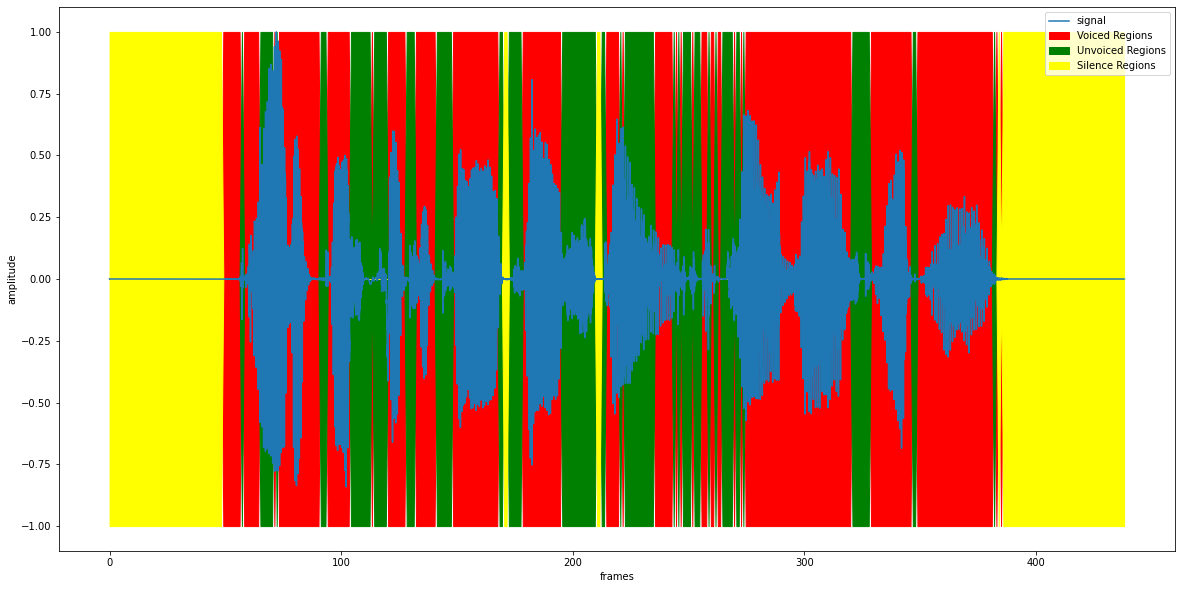

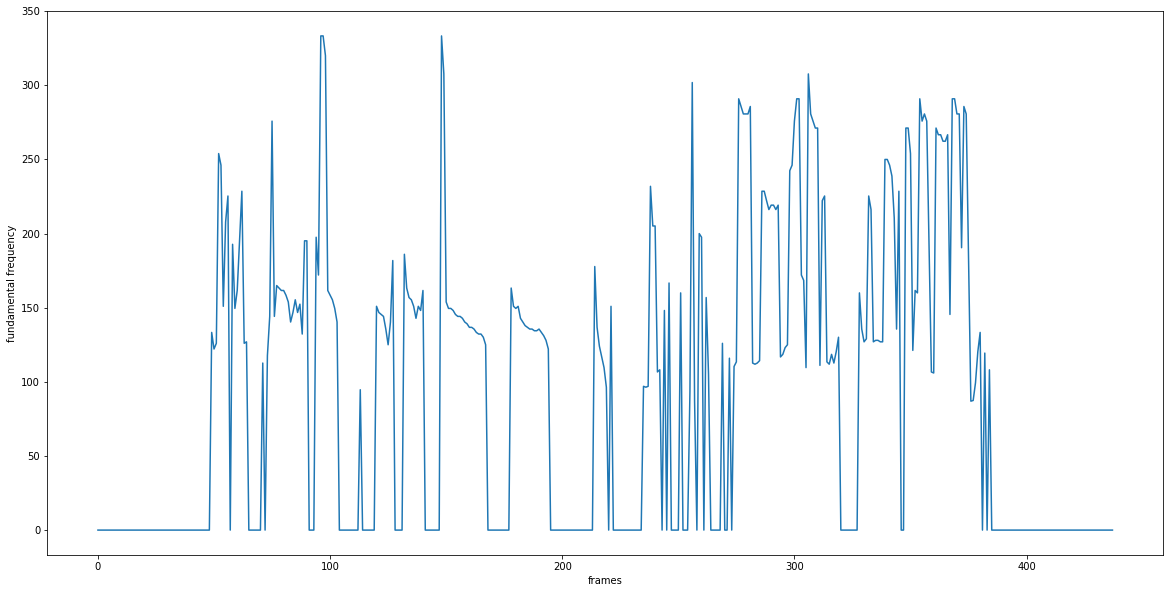

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(np.linspace(0,len(voiced_flags),len(sig)),sig, label='signal')
plt.fill_between(np.linspace(0,len(voiced_flags),len(voiced_flags)), (voiced_flags*1.), color='red', label='Voiced Regions')
plt.fill_between(np.linspace(0,len(voiced_flags),len(voiced_flags)), -(voiced_flags*1.), color='red')
plt.fill_between(np.linspace(0,len(voiced_flags),len(voiced_flags)), (unvoiced_flags*1.), color='green', label='Unvoiced Regions')
plt.fill_between(np.linspace(0,len(voiced_flags),len(voiced_flags)), -(unvoiced_flags*1.), color='green')
plt.fill_between(np.linspace(0,len(voiced_flags),len(voiced_flags)), (silence_flags*1.), color='yellow', label='Silence Regions')
plt.fill_between(np.linspace(0,len(voiced_flags),len(voiced_flags)), -(silence_flags*1.), color='yellow')
plt.legend()
plt.xlabel('frames')
plt.ylabel('amplitude')
plt.show()


plt.figure(figsize=(20,10))
plt.plot(estimated_pitch)
plt.xlabel('frames')
plt.ylabel('fundamental frequency')
plt.show()

<h4> <b> Part2 (Compute and plot the Short-Time Fourier Transfrom (STFT) of the speech signal) : </b>  This section describes the steps involved in computing the spectrogram of the speech signal and also restoring the speech signal from the the spectrogram.   </h4>

<dt> <h4> 1. Compute and plot the spectrogram </h4> </dt>

<dd> <h4> i. Segment the speech signal into short-time frames $s[n]$: 'frame_length'  and 'frame_step'. </h4> </dd>
<dd> <h4> ii. Compute 'N' point DFT of each of the frame $S[n,k]$, where $n$ denotes time-frame and $k$ denotes frequency bin. </h4> </dd>
<dd> <h4> iii. Compute log-manitude spectrum of each frame in decibels: $20\log|S[n,k]|$. </h4> </dd>
<dd> <h4> iv. Plot the matrix containing log magnitude spectra as a 3-D plot, time along $x$-axis, frequency along $y$-axis and magnitude of time-frequency bin as the intensity of the pixel. You can 'imshow' function to achieve this. </h4> </dd>
<dd> <h4> v. Write a function to plot waveform and spectrogram as subplots of a single figure with aligned time-axis. </h4> </dd>

<dt> <h4> 2. Plot narrow-band and wide-band spectrogram </h4> </dt>

<dd> <h4> i. Plot narrow-band and wide-band spectrograms of a male and female speakers.
 </h4> </dd>
<dd> <h4> ii. Report the 'frame_length' and 'frame_step' used in each of these cases. What are your observations </h4> </dd>

<dt> <h4> 3. Phase reconstruction - Reconstruct the waveform from the spectrogram </h4> </dt>

<dd> <h4>

i. Implement [Griffin-Lim algorithm](https://ieeexplore.ieee.org/document/1164317) to reconstruct speech signal from the magnitude of the STFT, i.e., $|S[n,k]|$

</h4> </dd>


In [ ]:
#All Imports
import numpy as np
import soundfile as sf
from numpy.lib import stride_tricks
import matplotlib.pyplot as plt


##########################################################
#Write a function to compute the spectrogram
##########################################################

def FrameSig(input,frameSize=400,frameShift=160,padding=False, window=None):
    if window=='hamming': w = 0.54-0.46*np.cos(2*np.pi*np.arange(frameSize)/(frameSize-1))
    else: w=np.ones(frameSize)
    output = []
    for si in range(0, len(input), frameShift):
      if(si+frameSize<=len(input)):
        fr = input[si:si+frameSize]
        output.append(fr*w)
      elif padding:
        fr = np.concatenate([input[si:], np.zeros(si+frameSize-len(input))], axis=0)
        output.append(fr*w)
    return np.asarray(output)

def stft(sig, nfft, frameSize, hopSize, window='hamming', logSpec=False):
    ##########################################################
    #Steps
    #1.Segment the speech signal into short time frames ( You may use "stride_tricks.as_strided" with appropriate arguments )
    #2.Multiply the frames with the window ( i.e rectangular, hamming, hanning etc )
    #3.Compute N-point DFT of of the frames ( You may use "np.fft.rfft" with appropriate arguments )
    #4.Compute Log magnitude spectrum of the frames in decibles
    #5.Return Log magnitude spectrogram
    ##########################################################
    ##########################################################
    #Complete the code
    framed_sig = FrameSig(sig, frameSize, hopSize, window=window)
    spec = np.fft.rfft(framed_sig, nfft, axis=-1)
    if logSpec:
      spec = 20*np.log10(np.abs(spec))
    return spec
    ##########################################################


In [ ]:
##########################################################
#Write a function to plot the spectrogram of the signal
##########################################################
def plotstft(sig,nfft,frameSize,hopSize):
    #Compute Log Magnitude Spectrogram using the already written "stft" fuction
    S = stft(sig,nfft,frameSize,hopSize, logSpec=True)
    ##########################################################
    #Steps
    #1.Plot the waveform and spectrogram as subplots of the single figure with aligned time axis
    #You may use ax.set_aspect("auto") for aligning the time frames.
    ##########################################################
    ##########################################################
    #Complete the code
    xl = 0
    xu = S.shape[0]
    yl = 0
    yu = S.shape[1]

    fig, ax = plt.subplots(2,1, figsize=(12,8))
    ax[0].plot(sig)
    ax[0].set_ylabel('Amplitude')
    plt.setp(ax[0], xticks=[], xticklabels=[])
    ax[1].imshow(S.T, origin='lower', aspect='auto', cmap='jet')
    ax[1].set_xlabel('Time(Sec)')
    ax[1].set_ylabel('Frequency(Hz)')
    plt.setp(ax[1], yticks=np.linspace(yl, yu, 5), yticklabels=['0','2k','4k','6k','8k'])
    plt.setp(ax[1], xticks=np.linspace(xl, xu, 5), xticklabels= np.round((np.linspace(xl, xu, 5)*hopSize)/16000, 1))
    plt.show()
    ##########################################################



 Narrowband Spectrogram




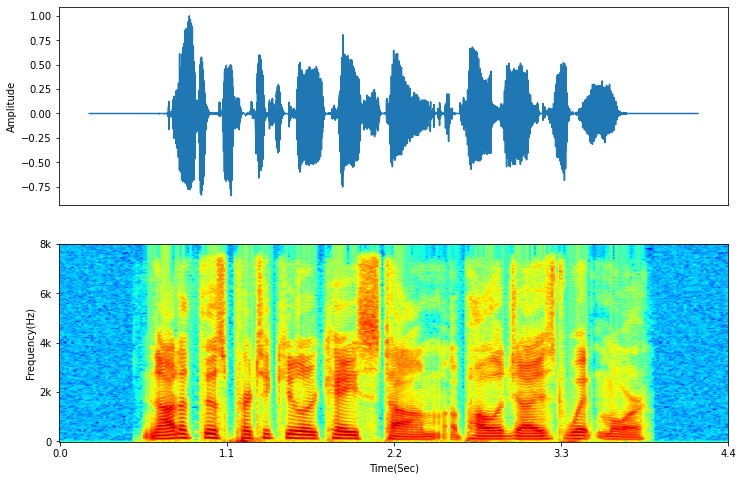



 Wideband Spectrogram




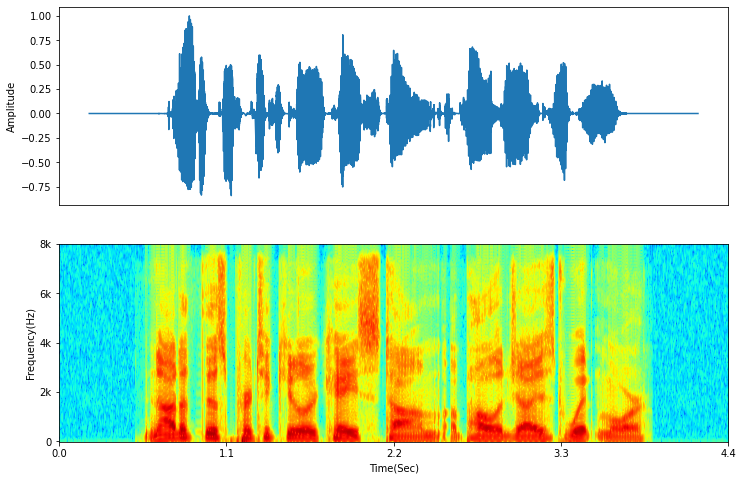

In [ ]:
wav_path='/content/drive/MyDrive/TalentSprint/Session3/clean_signal.wav'
sig, sr = sf.read(wav_path)

##########################################################
#Plot narrow band spectrogram : Set frameSize to cover at least one pitch period
##########################################################
print('\n\n Narrowband Spectrogram\n\n')
nfft = 512
frameSize = 512
hopSize = 256
plotstft(sig,nfft,frameSize,hopSize)

##########################################################
#Plot wide band spectrogram : Set frameSize as less than one pitch period
##########################################################
print('\n\n Wideband Spectrogram\n\n')
nfft = 512
frameSize = 128
hopSize = 64
plotstft(sig,nfft,frameSize,hopSize)



 Original Signal



 Reconstructed signal with Griffin-Lim


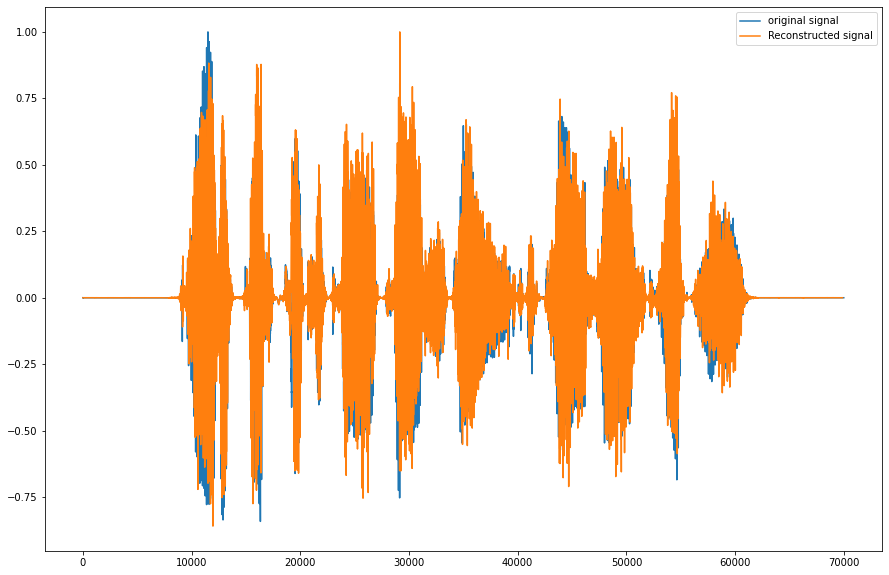

In [ ]:
##########################################################
#Compute the speech signal from the spectrogram - Use Griffin Lim Algorithm to estimate the phase
##########################################################
import numpy as np
import scipy.signal
from IPython.display import Audio, display

def istft(spec, frame_step):
  signal = np.fft.irfft(spec, axis=-1)
  frames, frame_length = signal.shape
  segments = -(-frame_length//frame_step)
  signal = np.pad(signal, [[0,segments],[0,segments*frame_step-frame_length]])
  signal = np.reshape(signal, [frames+segments, segments, frame_step])
  signal = np.transpose(signal, [1,0,2])
  signal = np.reshape(signal, [(frames+segments)*segments, frame_step])
  signal = signal[:(frames+segments-1)*segments, :]
  signal = np.reshape(signal, [segments, (frames + segments - 1), frame_step])
  signal = np.sum(signal, axis=-3)
  signal = np.reshape(signal, [(frames + segments - 1) * frame_step])

  return signal

def RecostructSignal(magSpec, frameLength, hopLength):
    ##########################################################
    #Steps
    #1.Griffin Lim Algorithm to estimate the phase
    #2.Reconstruct speech signal from magnitude and estimated phase
    #3.Return the reconstructed speech signal
    ##########################################################
    ##########################################################
    #Complete the code
    ##########################################################
    n_iter = 100
    magSpec = magSpec
    n_fft = (magSpec.shape[-1]-1)*2
    phase = np.exp(2j * np.pi * np.random.uniform(0,1,magSpec.shape))

    for i in range(n_iter):
        sig = istft(magSpec*phase, frame_step=hopLength)
        spec = stft(sig, n_fft, frameLength, hopLength)
        phase = spec/(np.maximum(np.abs(spec),1e-3))

    sig = istft(magSpec*phase, frame_step=hopLength)
    return sig

nfft = 512
frameSize = 512
hopSize = 256
spec = stft(sig, nfft, frameSize, hopSize)
magSpec = np.abs(spec)


reconstructed_signal = RecostructSignal(magSpec, frameSize, hopSize)
sf.write('/content/drive/MyDrive/TalentSprint/Session3//griffin_lim_reconstructed.wav', reconstructed_signal/max(abs(reconstructed_signal)), 16000)
print('\n Original Signal')
display(Audio('/content/drive/MyDrive/TalentSprint/Session3//clean_signal.wav'))
print('\n Reconstructed signal with Griffin-Lim')
display(Audio('/content/drive/MyDrive/TalentSprint/Session3//griffin_lim_reconstructed.wav'))
plt.figure(figsize=(15,10))
plt.plot(sig/max(abs(sig)), label='original signal')
plt.plot(reconstructed_signal/max(abs(reconstructed_signal)), label='Reconstructed signal')
plt.legend()
plt.show()

<h4> <b> Part3 (Feature extraction) : </b>  This section describes the steps involved in extracting MFCC features</h4>


<dt> <h4> 0. Relation between Mel and linear scale  </h4> </dt>
<dd> <h4> - Convert Hertz (f) to Mel (m) scale : m = 2595 $log_{10}$ (1+$\frac{f}{700}$) </h4> </dd>
<dd> <h4> - Convert Mel (m) to Hertz (h) : f = $700(10^{\frac{m}{2595}}-1)$ </h4> </dd>

<dt> <h4> 1. Extracting log-Mel-filterbank energy coefficients  </h4> </dt>

<dd> <h4> - Write a function to compute log-Mel-filterbank energy coefficients by warping the power-spectrum along the Mel-axis. Please note the function for Mel-weights is provided herewith.  </h4> </dd>

<dt> <h4> 2. Extracting Mel frequency cepstral coefficients (MFCCs) </h4> </dt>


<dd> <h4> - Write a function to compute Mel frequency cepstral coefficients (MFCCs) by taking discrete cosine transform of the log-Mel-filterbank energy coefficients.  </h4> </dd>


<dd> <h4> - Write a function to extract delta and acceleration coefficients from cepstral/MFCC features.    </h4> </dd>





In [ ]:
import numpy as np
import soundfile as sf
from numpy.lib import stride_tricks
from scipy.fftpack import dct
from scipy.fftpack import idct
import scipy.optimize
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio, display


##########################################################
#Write a function to compute the power spectrogram (This function is slightly different from one written in part1/part2)
##########################################################

def FrameSig(input,frameSize=400,frameShift=160,padding=False, window=None):
    if window=='hamming': w = 0.54-0.46*np.cos(2*np.pi*np.arange(frameSize)/(frameSize-1))
    else: w=np.ones(frameSize)
    output = []
    for si in range(0, len(input), frameShift):
      if(si+frameSize<=len(input)):
        fr = input[si:si+frameSize]
        output.append(fr*w)
      elif padding:
        fr = np.concatenate([input[si:], np.zeros(si+frameSize-len(input))], axis=0)
        output.append(fr*w)
    return np.asarray(output)

def stft(sig, nfft, frameSize, hopSize, window='hamming', power_spec=False):
    ##########################################################
    #Steps
    #1.Segment the speech signal into short time frames ( You may use "stride_tricks.as_strided" with appropriate arguments )
    #2.Multiply the frames with the window ( i.e rectangular, hamming, hanning etc )
    #3.Compute N-point DFT of of the frames ( You may use "np.fft.rfft" with appropriate arguments )
    #4.Compute magnitude spectrum of the frames
    #5.Compute the power spectrum of the frames
    #6.Return power spectrum of the frames
    ##########################################################
    ##########################################################
    #Complete the code
    framed_sig = FrameSig(sig, frameSize, hopSize, window=window)
    spec = np.fft.rfft(framed_sig, nfft, axis=-1)
    if power_spec:
      return np.power(np.abs(spec),2)
    return spec

##########################################################
#Load wavefile
##########################################################

wav_path='/content/drive/MyDrive/TalentSprint/Session3/example.wav'
sig, sr = sf.read(wav_path)
display(Audio(wav_path))
##########################################################
#Filter Bank
##########################################################
#You may change this arguments based on your requirement

def hz_to_mel(frequencies):
    frequencies = np.asanyarray(frequencies)
    f_min = 0.0
    f_sp = 200.0 / 3

    mels = (frequencies - f_min) / f_sp

    # Fill in the log-scale part

    min_log_hz = 1000.0  # beginning of log region (Hz)
    min_log_mel = (min_log_hz - f_min) / f_sp  # same (Mels)
    logstep = np.log(6.4) / 27.0  # step size for log region

    if frequencies.ndim:
        # If we have array data, vectorize
        log_t = frequencies >= min_log_hz
        mels[log_t] = min_log_mel + np.log(frequencies[log_t] / min_log_hz) / logstep
    elif frequencies >= min_log_hz:
        # If we have scalar data, heck directly
        mels = min_log_mel + np.log(frequencies / min_log_hz) / logstep

    return mels

def mel_to_hz(mels):
  mels = np.asanyarray(mels)
  f_min = 0.0
  f_sp = 200.0 / 3
  freqs = f_min + f_sp * mels

  # And now the nonlinear scale
  min_log_hz = 1000.0  # beginning of log region (Hz)
  min_log_mel = (min_log_hz - f_min) / f_sp  # same (Mels)
  logstep = np.log(6.4) / 27.0  # step size for log region

  if mels.ndim:
      # If we have vector data, vectorize
      log_t = mels >= min_log_mel
      freqs[log_t] = min_log_hz * np.exp(logstep * (mels[log_t] - min_log_mel))
  elif mels >= min_log_mel:
      # If we have scalar data, check directly
      freqs = min_log_hz * np.exp(logstep * (mels - min_log_mel))

  return freqs

def generate_fbank(nfilt, NFFT, sample_rate):
  high_freq_mel = hz_to_mel(sample_rate/2)
  fbank = np.zeros((nfilt, int(1 + NFFT // 2)), dtype=pow_spec.dtype)
  fftfreqs = np.arange(NFFT//2+1)*((sample_rate/2)/(NFFT//2))
  mels = np.linspace(0, high_freq_mel, nfilt + 2)
  mel_f = mel_to_hz(mels)
  fdiff = np.diff(mel_f)
  ramps = np.subtract.outer(mel_f, fftfreqs)
  for i in range(nfilt):
      lower = -ramps[i] / fdiff[i]
      upper = ramps[i + 2] / fdiff[i + 1]
      fbank[i] = np.maximum(0, np.minimum(lower, upper))
  return fbank


##########################################################
#Write a function to Mel frequency cepstral coefficients ( MFCCs )
##########################################################
def ComputeMFCC(LogMelFilterBank):
    ###########################################################################
    #Steps
    #1.You may use "idct" with appropriate arguments
    #2.Return Mel frequency cepstral coefficients ( MFCCs )
    ###########################################################################
  mfcc = idct(LogMelFilterBank, norm='ortho', type=3, axis=-1)
  return mfcc


##########################################################
#Write a function to add delta and acceleration coefficients to MFCCs
##########################################################
def derivative(input, order=5):
  delta = np.zeros_like(input)
  for t in range(len(input)):
    sum = np.zeros(len(input[t]))
    denom = 0
    for k in range(1, order+1):
      if (t-k)<0:
        sum += (k*input[t+k])
      if (t+k)>=len(input):
        sum -= (k*input[t-k])
      if (t-k)>=0 and (t+k)<len(input):
        sum += (k*(input[t+k]-input[t-k]))
      denom += k**2
    delta[t] = sum / denom
  return delta

def addDelta(MFCC):
    ############################################################################
    #Steps
    #1.Compute delta coefficients and delta-delta (i.e acceleration) coefficients
    #2.Add delta and delta-delta ( i.e acceleration ) coefficients to original Mel cepstral coefficients
    #3.Return delta and delta-delta added coefficients
    ############################################################################
  delta = derivative(MFCC)
  delta_delta = derivative(delta)
  features = np.concatenate([MFCC, delta, delta_delta], axis=-1)
  return features

##########################################################
#Write a function to compute CMVN features from the Mel frequency cepstral coefficients ( MFCCs )
##########################################################
def ComputeCMVN(MFCC,MeanNormalize=True,VarNormalize=True):
    ###########################################################################
    #Compute the CMVN features with specific window length
    ###########################################################################
  cmean = np.mean(MFCC, axis=0, keepdims=True)
  cvar = np.var(MFCC, axis=0, keepdims=True)
  mfcc = MFCC
  if MeanNormalize:
    mfcc = mfcc - cmean
  if VarNormalize:
    mfcc = mfcc/(np.sqrt(cvar)+1e-7)
  return mfcc

############################################################################
#Plot original linear spectrogram and reconstructed linear spectrogram from Mel-filter bank coefficients and compare them
############################################################################
nfft = 512
frameSize = 512
hopSize = 256
sample_rate=16000
nmels=80

pow_spec = stft(sig, nfft, frameSize, hopSize, power_spec=True)
fbank = generate_fbank(nmels, nfft, sample_rate)
fbank_coeffs = pow_spec@(fbank.T)
log_fbank_coeffs = np.log10(fbank_coeffs+1e-8)
mfccs = ComputeMFCC(log_fbank_coeffs)


<h4> <b> Discriminative approach to speaker verification(x-vector model) : </b>  This section describes the steps required to extract speaker embedding using the DNN framework. We use the PyTorch toolkit for this task.

<dt> <h4> <b> Feature Extraction </b> <dt> <h4>
<dt> <h4> 1. Extract 64-dimensional log-Mel filter bank energies from the speech signal and use them as features to train the speaker classification network
  </h4> </dt>

<dt> <h4> <b> Architecture </b> <dt> <h4>


<img src ="https://raw.githubusercontent.com/SpeechPublications/AIET/main/xvector.png" >

<dt> <h4> 1. Frame Level Layers </h4> </dt>
<dd> <h4> - Four layers of 1D CNN layers to extract high level speaker discriminative representations from the feature vectors.   </h4> </dd>
<dt> <h4> 2. Stats Pooling Layer </h4> </dt>
<dd> <h4> - Computes temporal mean and variance of framelevel representations to extract fixed dimensional embedding from the variable length representations.  </h4> </dd>
<dt> <h4> 3. Segment level layers </h4> </dt>
<dd> <h4> - A pair of fully connected layers and output layer as a classifier. The activations of first or second fully connected layers is considered as x-vector.</h4> </dd>
<dt> <h4> <b> Dataset

[link to data](https://drive.google.com/drive/folders/1gOraB1OC3x1QczkZJL_E9wxspD_0Db3S?usp=sharing)

<dt> <h4> 1. Training data : Speech from 100 speakers is provided to train the speaker classification network.
  </h4> </dt>
  <dt> <h4> 2. Testing data : Speech from 40 speakers is provided to test the ASV system.
  </h4> </dt>
<dt> <h4> <b> Training </b> <dt> <h4>
<dt> <h4> 1. Write a dataset loader to pass the features to the network  </h4> </dt>
<dt> <h4> 2. As it is not possible to form the batch with variable length speech signal, typically, it is preferred to obtain a chunk ( 2 to 6 seconds ) of data from each utterance and form batches to train the network. Please follow the same for training the network.    </h4> </dt>
<dt> <h4> 3. Compute cross entropy loss between true and predicted labels and use adam optimizer to train the network </h4> </dt>
<dt> <h4> <b> Inference (Testing) </b> <dt> <h4>
<dt> <h4> 1. Discard the logistic classification layer and extract speaker embeddings from the outputs of the dense layer in segment-level layers for both claimed identity and test utterance
 </h4> </dt>
<dt> <h4> 2. Perform the cosine scoring between claimed identity ( enroll ) and test embeddings to compute the speaker similarity between them </h4> </dt>
<dt> <h4> 3. Compute Equal Error Rate (EER) to quantify the performance of the ASV system. </h4> </dt>



In [ ]:
!pip install python_speech_features

import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import DataLoader
from torch import optim
from sklearn.metrics import accuracy_score
import os
import soundfile as sf
from numpy.lib import stride_tricks
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc
import glob
import os
import librosa
import random
import sklearn.metrics

def load_wav(audio_filepath, min_dur_sec=3):
    audio_data,sr  = librosa.load(audio_filepath,sr=None)
    len_file = len(audio_data)
    if len_file <int(min_dur_sec*sr):
        dummy=np.zeros((1,int(min_dur_sec*sr)-len_file))
        extened_wav = np.concatenate((audio_data,dummy[0]))
    else:
        extened_wav = audio_data
    return extened_wav

def feature_extraction(filepath, min_dur_sec=3):
    audio_data = load_wav(filepath,min_dur_sec=min_dur_sec)
    mel_filter_banks = librosa.feature.melspectrogram(audio_data, n_mels=64, win_length=400,hop_length=160)
    mag_T = np.log10(mel_filter_banks+1e-5).T
    #mu = np.mean(mag_T, 0, keepdims=True)
    #std = np.std(mag_T, 0, keepdims=True)
    #return (mag_T - mu) / (std + 1e-5)
    return mag_T

def store_features(feature_list):
    i=0
    input_data=[]
    input_labels=[]
    for row in feature_list:
        print(i)
        i=i+1
        filepath, label = row.split(' ')
        extract_feats = feature_extraction(filepath)
        input_data.append(extract_feats)
        input_labels.append(int(label))

    np.save('xvec_features.npy',input_data)
    np.save('xvec_labels.npy',input_labels)

#read_train = [line.rstrip('\n') for line in open('train.txt')]
#store_features(read_train)

#####################################################
#Network Architecture
#####################################################

class Xvector(nn.Module):
    #################################################
    ##Takes input as wave file and produces speaker logits
    #################################################
    def __init__(self, numSpk):
        super(Xvector, self).__init__()

        self.numSpk = numSpk
        self.n_mels     = 64
        self.log_input  = True

        self.instancenorm   = nn.InstanceNorm1d(self.n_mels)
        self.torchfb        = torch.nn.Sequential(
                torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=512, win_length=400, hop_length=160, window_fn=torch.hamming_window, n_mels=self.n_mels)
                )

        p_dropout = 0.1

        self.tdnn1 = nn.Conv1d(in_channels=self.n_mels, out_channels=64, kernel_size=5, dilation=1)
        self.bn_tdnn1 = nn.BatchNorm1d(64, momentum=0.1, affine=True)
        self.dropout_tdnn1 = nn.Dropout(p=p_dropout)

        self.tdnn2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, dilation=2)
        self.bn_tdnn2 = nn.BatchNorm1d(64, momentum=0.1, affine=True)
        self.dropout_tdnn2 = nn.Dropout(p=p_dropout)

        self.tdnn3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7, dilation=3)
        self.bn_tdnn3 = nn.BatchNorm1d(64, momentum=0.1, affine=True)
        self.dropout_tdnn3 = nn.Dropout(p=p_dropout)

        self.tdnn4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1, dilation=1)
        self.bn_tdnn4 = nn.BatchNorm1d(64, momentum=0.1, affine=True)
        self.dropout_tdnn4 = nn.Dropout(p=p_dropout)

        self.tdnn5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1, dilation=1)
        self.bn_tdnn5 = nn.BatchNorm1d(128, momentum=0.1, affine=True)
        self.dropout_tdnn5 = nn.Dropout(p=p_dropout)

        self.fc1 = nn.Linear(256,256)
        self.bn_fc1 = nn.BatchNorm1d(256, momentum=0.1, affine=True)
        self.dropout_fc1 = nn.Dropout(p=p_dropout)

        self.fc2 = nn.Linear(256,256)
        self.bn_fc2 = nn.BatchNorm1d(256, momentum=0.1, affine=True)
        self.dropout_fc2 = nn.Dropout(p=p_dropout)

        self.fc3 = nn.Linear(256,self.numSpk)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out

    def forward(self, x):
        x_input = x
        #if self.training:
        #  x_input = self.instancenorm(x_input)
        #x  = x.reshape(-1,x.size()[-1])
        #if self.training:
        #    with torch.no_grad():
        #        with torch.cuda.amp.autocast(enabled=False):
        #            x = self.torchfb(x)+1e-6
        #            if self.log_input: x = x.log()
        #            x_input = self.instancenorm(x)
        #x_input = x
        x = self.dropout_tdnn1(self.bn_tdnn1(self.tdnn1(x_input)))
        x = self.dropout_tdnn2(self.bn_tdnn2(self.tdnn2(x)))
        x = self.dropout_tdnn3(self.bn_tdnn3(self.tdnn3(x)))
        x = self.dropout_tdnn4(self.bn_tdnn4(self.tdnn4(x)))
        x = self.dropout_tdnn5(self.bn_tdnn5(self.tdnn5(x)))

        eps = 0.0000001
        if self.training:
            shape = x.size()
            noise = torch.FloatTensor(shape)
            noise = noise.to("cuda")
            torch.randn(shape, out=noise)
            x += noise*eps

        mean = x.mean(dim=2)
        variance =  x.std(dim=2)
        stats = torch.cat((mean,variance),1)

        xvec = self.fc1(stats)
        x = self.dropout_fc1(self.bn_fc1(xvec))
        x = self.dropout_fc2(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)

        # else:
        #     x = self.fc1(stats) #Typically considering this activation potential as speaker embedding generalizes well.
        #     #x = self.dropout_fc1(self.bn_fc1(self.fc1(stats)))
        #     #x = self.fc2(x) #These activation potentials are slightly overfitted to training speakers and may not generalize well.

        return x, xvec

#######################################
#Define cross entropy loss function
#######################################
criterion = nn.CrossEntropyLoss()
#######################################
#Write data set loader
#######################################

class DataGenerator():
    def __init__(self, feat_file, label_file, maxlen=400):
        self.npy_data=np.load(feat_file,allow_pickle=True)
        self.labels=np.load(label_file,allow_pickle=True)
        self.spec_len=maxlen

    def __len__(self):
        return len(self.npy_data)

    def __getitem__(self, idx):
        class_id = self.labels[idx]
        features=self.npy_data[idx].T
        randtime = np.random.randint(0, features.shape[1]-self.spec_len)
        mfbanks = features[:, randtime:randtime+self.spec_len]
        sample = {'features': torch.from_numpy(np.ascontiguousarray(mfbanks)), 'labels': torch.from_numpy(np.ascontiguousarray(int(class_id)))}
        return sample

def collate_fn(batch):
    targets = []
    specs = []
    for sample in batch:
        specs.append(sample['features'])
        targets.append((sample['labels']))
    return specs, targets


#######################################
#Train the network
#######################################
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model=Xvector(100).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0, betas=(0.9, 0.98), eps=1e-9)

batch_size=128
feat_file = '/content/drive/MyDrive/TalentSprint/Session3/xvec_features.npy'
label_file = '/content/drive/MyDrive/TalentSprint/Session3/xvec_labels.npy'

dataset_train = DataGenerator(feat_file, label_file, maxlen=300)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

check_points_path='/content/drive/MyDrive/TalentSprint/Session3/check_points'
os.system('mkdir -p %s'%check_points_path)

def train(dataloader_train,epoch):
    train_loss_list=[]
    full_preds=[]
    full_gts=[]
    model.train()

    for i_batch, sample_batched in enumerate(dataloader_train):
        features = torch.from_numpy(np.asarray([torch_tensor.numpy() for torch_tensor in sample_batched[0]])).float()
        labels = torch.from_numpy(np.asarray([torch_tensor[0].numpy() for torch_tensor in sample_batched[1]]))
        features, labels         = features.to(device),labels.to(device)
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits,x_vec = model(features)
        loss = criterion(pred_logits,labels)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        predictions = np.argmax(pred_logits.detach().cpu().numpy(),axis=1)
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)

    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
    model_save_path = os.path.join(check_points_path, 'best_check_point_'+str(epoch)+'_'+str(mean_loss))
    state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
    torch.save(state_dict, model_save_path)

for epoch in range(100):
  train(dataloader_train, epoch)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Total training loss 3.0501037732414575 and training Accuracy 0.2955344133024771 after 0 epochs
Total training loss 1.9917422351629839 and training Accuracy 0.5130710551127111 after 1 epochs
Total training loss 1.5670020580291748 and training Accuracy 0.6011828233479043 after 2 epochs
Total training loss 1.3162347946477972 and training Accuracy 0.6551812805348418 after 3 epochs
Total training loss 1.1536607133305592 and training Accuracy 0.697351504242736 after 4 epochs
Total training loss 1.0327278595903646 and training Accuracy 0.7263221050827119 after 5 epochs
Total training loss 0.9258986251509708 and training Accuracy 0.7504071312248222 after 6 epochs
Total training loss 0.8554456959600034 and training Accuracy 0.7670352275649267 after 7 epochs
Total training loss 0.8168383908012639 and training Accuracy 0.7728636324676438 after 8 epochs
Total training loss 0.7784957535888838 and trai

In [ ]:
#######################################
#Inference from the network
#######################################
model.eval()

baseDir = '/content/drive/MyDrive/TalentSprint/Session3/'
evaluationDir = baseDir+'evaluation_data/'

f = open(baseDir+'Verification_trials.txt', 'r')
lines = f.readlines()
targets = []
predicted = []
for line in lines[0:200]:
  label, enrollment_path, test_path = line.strip().split(' ')
  targets.append(int(label))
  enroll_feats=feature_extraction(evaluationDir+enrollment_path).T
  test_feats=feature_extraction(evaluationDir+test_path).T
  with torch.no_grad():
    enroll_features = torch.from_numpy(np.asarray([enroll_feats ])).float()
    test_features = torch.from_numpy(np.asarray([test_feats ])).float()
    enroll_features = enroll_features.to(device)
    test_features = test_features.to(device)
    pred_logits,x_vec_enroll = model(enroll_features)
    pred_logits,x_vec_test = model(test_features)
    x_vec_enroll=x_vec_enroll.cpu().numpy().reshape(-1,)
    x_vec_test=x_vec_test.cpu().numpy().reshape(-1,)
    cos_sim = np.dot(x_vec_enroll, x_vec_test)/(np.linalg.norm(x_vec_enroll)*np.linalg.norm(x_vec_test))
    predicted.append(cos_sim)
    #print(label, cos_sim)

#######################################
#Evaluate the performance i.e Report the EER
#######################################
def compute_eer(label, pred, positive_label=1):
  fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, pos_label=positive_label)
  fnr = 1 - tpr
  eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
  eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = (eer_1 + eer_2) / 2
  return eer

eer = compute_eer(np.array(targets), np.array(predicted))
print('\n\n EER=', eer)



 EER= 0.20476190476190478
